### Set hyperparameters and load data

In [125]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [126]:
#from utils.train import train
import random

import numpy as np
import torch


In [127]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

In [128]:
set_seed(42)
use_pre_paired = True
learning_rate = 1e-5
epochs = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_size = 16
pooling = 'global_avg'
patience = 100
alpha = 1.0
target_decay = 0.996

In [129]:
# load data 
from QCCL.Data import load_graphs

basic_data, _ = load_graphs()

	Collected 1 sample from null_ops.
	Collected 4 samples from commutations.
	Collected 7 samples from equivalences.
	Collected 7 samples from combined.
Loaded 19 samples and 19 quantum circuits from subset.


### Train-Validation-Test Split

In [130]:
# from sklearn.model_selection import train_test_split
# test_mask = torch.zeros(len(basic_data), dtype=torch.bool)
# test_mask[12:14] = True
# val_mask = torch.zeros(len(basic_data), dtype=torch.bool)
# val_mask[14:17] = True

# train_data = [basic_data[i] for i in range(len(basic_data)) if not test_mask[i] and not val_mask[i]]
# val_data = [basic_data[i] for i in range(len(basic_data)) if val_mask[i]]
# test_data = [basic_data[i] for i in range(len(basic_data)) if test_mask[i]]

# # train_data, val_data = train_test_split(train_data, train_size=0.8, shuffle=True)
# print('Data split:')
# print('train:', len(train_data), '(', round((len(train_data) / len(basic_data)) * 100, 1), '%)')
# print('val:', len(val_data), '(', round((len(val_data) / len(basic_data)) * 100, 1), '%)')
# print('test:', len(test_data), '(', round((len(test_data) / len(basic_data)) * 100, 1), '%)')

# train_dataset = GraphDataset(train_data, pre_paired=use_pre_paired)
# val_dataset = GraphDataset(val_data, pre_paired=use_pre_paired)
# test_dataset = GraphDataset(test_data, pre_paired=use_pre_paired)

In [131]:
from QCCL.Data import split_dataset, GraphDataset

train_data, val_data, test_data = split_dataset(basic_data, 0.58, 0.22, use_pre_paired=use_pre_paired)
train_dataset = GraphDataset(train_data, pre_paired=use_pre_paired)
val_dataset = GraphDataset(val_data, pre_paired=use_pre_paired)


Starting dataset split...
Total dataset size: 19
Composite transformations size: 7
Splitting into 12 training, 4 validation, and 3 test circuits...
Data split completed:
Training set: 12 samples, (63.16%)
Validation set: 4 samples, (21.05%)
Test set: 3 samples, (15.79%)


In [132]:
batch_size = len(train_dataset)
print('Batch size:', batch_size)

Batch size: 12


In [133]:
n_features = train_dataset[0][0].x.shape[1] if use_pre_paired else train_dataset[0].x.shape[1]
print(f'Number of features in the dataset: {n_features}')

Number of features in the dataset: 6


In [134]:
from QCCL.Models import build_model

model = build_model(n_features, embedding_size, 'byol', num_layers=5, proj_output_size=4, device=device, hidden_size=64)


Building model with 5 GCNConv layers and projection size 4...
BYOL model built successfully.


In [135]:
# from torch.optim import Adam

# optimizer = Adam(model.online_model.parameters(), lr=learning_rate)
# history = model.train(train_dataset, val_dataset, optimizer=optimizer, epochs=epochs, batch_size=batch_size, patience=patience, verbose=False)

In [136]:
from QCCL.utils import train_byol

history = train_byol(model, train_dataset, val_dataset, 
                     tau=target_decay,
                     epochs=epochs, 
                     batch_size=batch_size, 
                     lr=learning_rate, 
                     patience=patience, 
                     warmup=20,
                     ema_alpha=alpha, 
                     verbose=False, 
                     device=device, 
                     compute_grads=True)

EMA Loss:  False


Training:  32%|███▏      | 324/1000 [00:42<01:29,  7.56epoch/s, loss=0.0214, val_loss=0.0517]

Early stopping due to no improvement in validation loss. Epochs run:  324
Restoring model to the state with the best validation loss.


In [137]:
# from QCCL.utils import train_byol

# history = train_byol(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, temperature, device, patience= patience, verbose=False)

<function matplotlib.pyplot.show(close=None, block=None)>

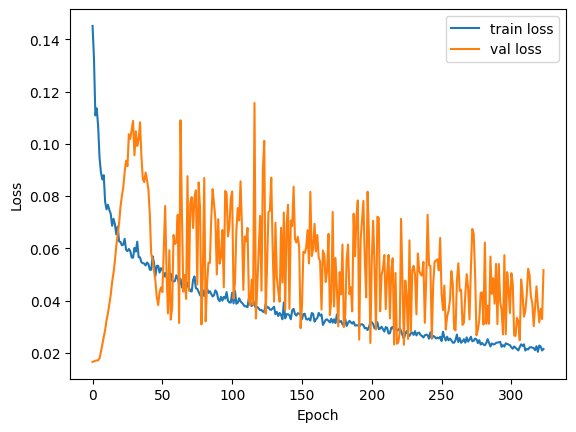

In [138]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
# show epoch with best validation loss
# best_epoch = len(history['val_loss']) - patience
# plt.axvline(best_epoch, color='black', linestyle='--', label='best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [139]:
history['train_loss'][0]

0.14516572654247284

In [140]:
history['avg_grad_norm_l1_per_param'][0]

88.3434034962549

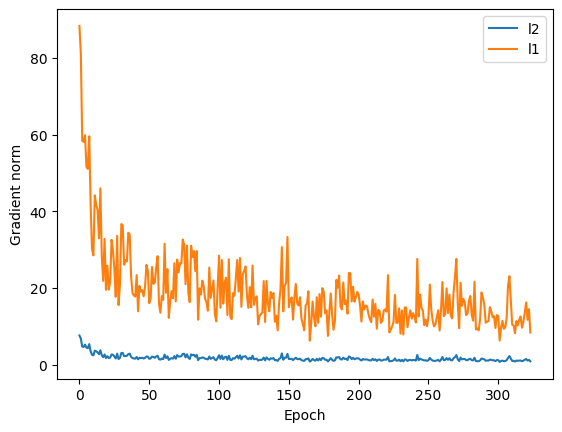

In [141]:
# plot gradients
plt.plot(history['grad_norm_l2'], label='l2')
plt.plot(history['avg_grad_norm_l1_per_param'], label='l1')
plt.xlabel('Epoch')
plt.ylabel('Gradient norm')
plt.legend()
plt.show()

### Notice that the training is much smoother wrt SimCLR

In [142]:
from QCCL.Data import from_nx_to_geometric

# visualize TRAINING results
idx1, idx2 = np.random.choice(len(train_dataset), 2, replace=False)

pos1 = from_nx_to_geometric(train_dataset.graphs[idx1][0])
pos2 = from_nx_to_geometric(train_dataset.graphs[idx1][1])

neg1 = from_nx_to_geometric(train_dataset.graphs[idx2][0])
neg2 = from_nx_to_geometric(train_dataset.graphs[idx2][1])

In [143]:
# print embeddings
gnn = model.get_gnn()

# pos1, pos2 = val_dataset[0]
# neg1, neg2 = val_dataset[1]

# Extract embeddings
emb1 = gnn(pos1)
emb2 = gnn(pos2)

neg_emb1 = gnn(neg1)
neg_emb2 = gnn(neg2)

In [144]:
print('Positive pair:')
print('Embedding 1:', emb1)
print('Embedding 2:', emb2)

print('Negative pair:')
print('Embedding 1:', neg_emb1)
print('Embedding 2:', neg_emb2)

Positive pair:
Embedding 1: tensor([[0.0000, 0.0000, 0.0319, 0.0356, 0.0000, 0.0398, 0.0011, 0.0258, 0.0238,
         0.0000, 0.0241, 0.0058, 0.0139, 0.0050, 0.0363, 0.0006]],
       grad_fn=<MeanBackward1>)
Embedding 2: tensor([[0.0000, 0.0000, 0.0385, 0.0343, 0.0000, 0.0425, 0.0021, 0.0210, 0.0190,
         0.0000, 0.0240, 0.0121, 0.0141, 0.0007, 0.0350, 0.0007]],
       grad_fn=<MeanBackward1>)
Negative pair:
Embedding 1: tensor([[0.0000, 0.0000, 0.0221, 0.0140, 0.0000, 0.0250, 0.0008, 0.0232, 0.0219,
         0.0010, 0.0094, 0.0220, 0.0254, 0.0073, 0.0197, 0.0102]],
       grad_fn=<MeanBackward1>)
Embedding 2: tensor([[0.0000, 0.0000, 0.0276, 0.0110, 0.0000, 0.0288, 0.0003, 0.0199, 0.0295,
         0.0004, 0.0084, 0.0232, 0.0250, 0.0068, 0.0236, 0.0099]],
       grad_fn=<MeanBackward1>)


In [145]:
# check collapse by checking the distance between the embeddings
from torch.nn.functional import cosine_similarity

print('Cosine similarity between positive pair:', cosine_similarity(emb1, emb2))
print('Cosine similarity between negative pair:', cosine_similarity(neg_emb1, neg_emb2))

# check if the embeddings are different
print('Cosine similarity between positive and negative pair:', cosine_similarity(emb1, neg_emb1))

# check if the embeddings are different
print('Cosine similarity between positive and negative pair:', cosine_similarity(emb2, neg_emb2))

Cosine similarity between positive pair: tensor([0.9892], grad_fn=<SumBackward1>)
Cosine similarity between negative pair: tensor([0.9885], grad_fn=<SumBackward1>)
Cosine similarity between positive and negative pair: tensor([0.8780], grad_fn=<SumBackward1>)
Cosine similarity between positive and negative pair: tensor([0.8806], grad_fn=<SumBackward1>)


In [146]:
online_model = model.online_model
target_model = model.target_model

output_online = online_model(pos1)
output_target = target_model(pos2)

print('Output online:', output_online)
print('Output target:', output_target)

Output online: tensor([[-0.0333, -0.3220,  0.0258, -0.0321]], grad_fn=<AddmmBackward0>)
Output target: tensor([[-0.0573, -0.0628, -0.0212, -0.0300]])


In [147]:
# compute loss for positive pair
from torch.nn import MSELoss
loss = MSELoss()
loss_pos = loss(output_online, output_target)
print('Loss for positive pair:', loss_pos)

Loss for positive pair: tensor(0.0175, grad_fn=<MseLossBackward0>)


In [149]:
# Visualize performance across all train set and validation set (mean cosine similarity, for positives and negatives separately)
from torch.nn.functional import cosine_similarity
from itertools import combinations

def compute_cosine_similarity(dataset, model):
    gnn = model.get_gnn()
    
    # compute embeddings for all graphs in the dataset
    embeddings = []
    for i in range(len(dataset)):
        graph_embeddings = []
        for idx in range(len(dataset.graphs[i])):
            graph = from_nx_to_geometric(dataset.graphs[i][idx])
            emb = gnn(graph)
            graph_embeddings.append(emb)
        embeddings.append(graph_embeddings)

    pos_sim = []
    neg_sim = []

    # compute cosine similarities for positive pairs
    for i in range(len(embeddings)):
        for emb1_idx, emb2_idx in combinations(range(len(embeddings[i])), 2):
            emb1 = embeddings[i][emb1_idx]
            emb2 = embeddings[i][emb2_idx]
            pos_sim.append(cosine_similarity(emb1, emb2).item())

    # compute cosine similarities for negative pairs
    for i in range(len(embeddings)):
        for j in range(len(embeddings)):
            if i != j:  
                for emb1 in embeddings[i]:
                    for emb2 in embeddings[j]:
                        neg_sim.append(cosine_similarity(emb1, emb2).item())

    return np.mean(pos_sim), np.mean(neg_sim)


In [150]:
train_pos_sim, train_neg_sim = compute_cosine_similarity(train_dataset, model)
val_pos_sim, val_neg_sim = compute_cosine_similarity(val_dataset, model)

print('Train set:')
print('Mean cosine similarity for positive pairs:', train_pos_sim)
print('Mean cosine similarity for negative pairs:', train_neg_sim)
print('\n')

print('Validation set:')
print('Mean cosine similarity for positive pairs:', val_pos_sim)
print('Mean cosine similarity for negative pairs:', val_neg_sim)


Train set:
Mean cosine similarity for positive pairs: 0.9174181950092316
Mean cosine similarity for negative pairs: 0.8565073196526167


Validation set:
Mean cosine similarity for positive pairs: 0.9210788011550903
Mean cosine similarity for negative pairs: 0.8982551391919454


## Linear evaluation

In [151]:
labels = torch.tensor([])
for i in range(len(test_data)):
    class_labels = torch.ones(len(test_data[i])) * i
    labels = torch.cat((labels, class_labels))
print(f"In test set there are {len(labels)} samples, distributed in {len(test_data)} classes as follows: {labels}")

In test set there are 15 samples, distributed in 3 classes as follows: tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.])


In [152]:
from sklearn.model_selection import train_test_split
# split in train and test for training the classifier
data = [from_nx_to_geometric(g) for gg in test_data for g in gg]
train, test, y_train, y_test = train_test_split(data, labels, test_size=0.4, stratify=labels)

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# get embeddings
train = torch.cat([gnn(d) for d in train])
test = torch.cat([gnn(d) for d in test])

# train a linear classifier (multi-class logistic regression) on top of the embeddings
print("Training a linear classifier on top of the embeddings...")
print("Logistic Regression (one-vs-rest) classifier:")
classifier = LogisticRegression().fit(train.detach().numpy(), y_train)
y_pred = classifier.predict(test.detach().numpy())
y_pred_probs = classifier.predict_proba(test.detach().numpy())
print(f"\tProbability of each class:\n\t {y_pred_probs}")
print(f"\tAccuracy of the classifier: {accuracy_score(y_test, y_pred)}")

print("Ground truth labels:")   
print(y_test)

Training a linear classifier on top of the embeddings...
Logistic Regression (one-vs-rest) classifier:
	Probability of each class:
	 [[0.33325463 0.33344215 0.33330321]
 [0.333536   0.33311686 0.33334714]
 [0.33358325 0.33304905 0.3333677 ]
 [0.33349412 0.333166   0.33333988]
 [0.33358474 0.33304814 0.33336712]
 [0.33335225 0.333334   0.33331375]]
	Accuracy of the classifier: 0.5
Ground truth labels:
tensor([1., 2., 2., 0., 0., 1.])
